## Support Vector Machine with soft margin

硬间隔支持向量机，它可以在严格线性可分的数据集上工作的很好，但对于非严格线性可分的情况往往就表现很差了

那怕仅含有一个异常点，对硬间隔支持向量机的训练影响就很大，我们希望它能具有一定的包容能力，容忍哪些放错的点，但又不能容忍过度，我们可以引入变量$\xi$和一个超参$C$来进行控制，原始的优化问题更新为如下：  

$$
\min_{w,b,\xi} \frac{1}{2}w^Tw + C\sum_{i=1}^N\xi_i\\
s.t.~~~~y_i(w^Tx_i+b)\geq 1-\xi_i,i=1,2,...,N\\
\xi_i\geq0,i=1,2,...,N
$$  

这里$C$若越大，包容能力就越小，当取值很大时，就等价于硬间隔支持向量机，而$\xi$使得支持向量的间隔可以调整，不必像硬间隔那样，严格等于1

## Lagrangian Duality

#### Lagrange函数
关于原问题的Lagrange函数：  

$$
L(w,b,\xi,\lambda,\mu)=\frac{1}{2}w^Tw+C\sum_{i=1}^N\xi_i+\sum_{i=1}^N\lambda_i(1-\xi_i-y_i(w^Tx_i+b))-\sum_{i=1}^N\mu_i\xi_i\\
s.t.\mu_i\geq 0,\lambda_i\geq0,i=1,2,...,N
$$

$$
\min_{\lambda} \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\lambda_i\lambda_jy_iy_jx_i^Tx_j-\sum_{i=1}^N\lambda_i\\
s.t.\sum_{i=1}^N\lambda_iy_i=0,\\
0\leq\lambda_i\leq C,i=1,2,...,N
$$  
可以发现与硬间隔的不同是$\lambda$加了一个上界的约束$C$  


### Karush–Kuhn–Tucker conditions
$$
\frac{\partial L}{\partial w}=0\Rightarrow w^*=\sum_{i=1}^N\lambda_i^*y_ix_i\\
\frac{\partial L}{\partial b}=0\Rightarrow \lambda_i^*y_i=0\\
\frac{\partial L}{\partial \xi}=0\Rightarrow C-\lambda_i^*-\mu_i^*=0\\
\lambda_i^*(1-\xi_i^*-y_i({w^*}^Tx_i+b^*))=0\\
\mu_i^*\xi_i^*=0\\
y_i({w^*}^Tx_i+b^*)-1-\xi_i^*\geq0\\
\xi_i^*\geq0\\
\lambda_i^*\geq0\\
\mu_i^*\geq0\\
$$  

由KKT条件中的关系1，我们可以知道：  

$$
w^*=\sum_{i=1}^N\lambda_i^*y_ix_i
$$  

对于$b^*$的求解，我们可以取某点，其$0<\lambda_k^*<C$，由关系3,4,5可以推得到：${w^*}^Tx_k+b^*=y_k$，所以：  

$$
b^*=y_k-{w^*}^Tx_k
$$

## SMO algorithm for solving SVM

 

好了，最终模型得求解落到了对$\lambda^*$得求解上，求解过程与硬间隔一样，无非就是就是对$\lambda$多加了一个约束：$\lambda_i^*<=C$，具体而言需要对$\lambda_2^{new}$的求解进行更新：  


当$y_1\neq y_2$时：  

$$
L=max(0,\lambda_2^{old}-\lambda_1^{old})\\
H=min(C,C+\lambda_2^{old}-\lambda_1^{old})
$$  

当$y_1=y_2$时：  

$$
L=max(0,\lambda_2^{old}+\lambda_1^{old}-C)\\
H=min(C,\lambda_2^{old}+\lambda_1^{old})
$$  

更新公式：  

$$
\lambda_2^{new}=\left\{\begin{matrix}
H & \alpha_2^{unc}> H\\ 
\alpha_2^{unc} &  L \leq \alpha_2^{unc} \leq H\\
L & \alpha_2^{unc}<L
\end{matrix}\right.
$$

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import os
%matplotlib inline

In [78]:
def plot_decision_function(X, y, clf, support_vectors=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    # 绘制支持向量
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=80, c='none', alpha=0.7, edgecolor='red')
def sigmoid(x2):
    """
    sigmoid函数
    :param x2:
    :return:
    """
    x = copy.deepcopy(x2)
    if type(x) is int:
        x = 20.0 if x > 20.0 else x
        x = -100.0 if x < -100.0 else x
    else:
        # 避免下溢
        x[x > 20.0] = 20.0
        # 避免上溢
        x[x < -100.0] = -100.0
    return 1 / (1 + np.exp(-x))

"""
软间隔支持向量机的smo实现，放到ml_models.svm模块中
"""
class SoftMarginSVM(object):
    def __init__(self, epochs=100, C=1.0):
        self.w = None
        self.b = None
        self.alpha = None
        self.E = None
        self.epochs = epochs
        self.C = C
        # 记录支持向量
        self.support_vectors = None

    def init_params(self, X, y):
        """
        :param X: (n_samples,n_features)
        :param y: (n_samples,) y_i\in\{0,1\}
        :return:
        """
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = .0
        self.alpha = np.zeros(n_samples)
        self.E = np.zeros(n_samples)
        # 初始化E
        for i in range(0, n_samples):
            self.E[i] = np.dot(self.w, X[i, :]) + self.b - y[i]

    def _select_j(self, best_i):
        """
        选择j
        :param best_i:
        :return:
        """
        valid_j_list = [i for i in range(0, len(self.alpha)) if self.alpha[i] > 0 and i != best_i]
        best_j = -1
        # 优先选择使得|E_i-E_j|最大的j
        if len(valid_j_list) > 0:
            max_e = 0
            for j in valid_j_list:
                current_e = np.abs(self.E[best_i] - self.E[j])
                if current_e > max_e:
                    best_j = j
                    max_e = current_e
        else:
            # 随机选择
            l = list(range(len(self.alpha)))
            seq = l[: best_i] + l[best_i + 1:]
            best_j = random.choice(seq)
        return best_j

    def _meet_kkt(self, w, b, x_i, y_i, alpha_i):
        """
        判断是否满足KKT条件

        :param w:
        :param b:
        :param x_i:
        :param y_i:
        :return:
        """
        if alpha_i < self.C:
            return y_i * (np.dot(w, x_i) + b) >= 1
        else:
            return y_i * (np.dot(w, x_i) + b) <= 1

    def fit(self, X, y2, show_train_process=False):
        """

        :param X:
        :param y2:
        :param show_train_process: 显示训练过程
        :return:
        """
        y = copy.deepcopy(y2)
        y[y == 0] = -1
        # 初始化参数
        self.init_params(X, y)
        for _ in range(0, self.epochs):
            if_all_match_kkt = True
            for i in range(0, len(self.alpha)):
                x_i = X[i, :]
                y_i = y[i]
                alpha_i_old = self.alpha[i]
                E_i_old = self.E[i]
                # 外层循环：选择违反KKT条件的点i
                if not self._meet_kkt(self.w, self.b, x_i, y_i, alpha_i_old):
                    if_all_match_kkt = False
                    # 内层循环，选择使|Ei-Ej|最大的点j
                    best_j = self._select_j(i)

                    alpha_j_old = self.alpha[best_j]
                    x_j = X[best_j, :]
                    y_j = y[best_j]
                    E_j_old = self.E[best_j]

                    # 进行更新
                    # 1.首先获取无裁剪的最优alpha_2
                    eta = np.dot(x_i - x_j, x_i - x_j)
                    # 如果x_i和x_j很接近，则跳过
                    if eta < 1e-3:
                        continue
                    alpha_j_unc = alpha_j_old + y_j * (E_i_old - E_j_old) / eta
                    # 2.裁剪并得到new alpha_2
                    if y_i == y_j:
                        L = max(0., alpha_i_old + alpha_j_old - self.C)
                        H = min(self.C, alpha_i_old + alpha_j_old)
                    else:
                        L = max(0, alpha_j_old - alpha_i_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_old)

                    if alpha_j_unc < L:
                        alpha_j_new = L
                    elif alpha_j_unc > H:
                        alpha_j_new = H
                    else:
                        alpha_j_new = alpha_j_unc

                    # 如果变化不够大则跳过
                    if np.abs(alpha_j_new - alpha_j_old) < 1e-5:
                        continue
                    # 3.得到alpha_1_new
                    alpha_i_new = alpha_i_old + y_i * y_j * (alpha_j_old - alpha_j_new)
                    # 4.更新w
                    self.w = self.w + (alpha_i_new - alpha_i_old) * y_i * x_i + (alpha_j_new - alpha_j_old) * y_j * x_j
                    # 5.更新alpha_1,alpha_2
                    self.alpha[i] = alpha_i_new
                    self.alpha[best_j] = alpha_j_new
                    # 6.更新b
                    b_i_new = y_i - np.dot(self.w, x_i)
                    b_j_new = y_j - np.dot(self.w, x_j)
                    if self.C > alpha_i_new > 0:
                        self.b = b_i_new
                    elif self.C > alpha_j_new > 0:
                        self.b = b_j_new
                    else:
                        self.b = (b_i_new + b_j_new) / 2.0
                    # 7.更新E
                    for k in range(0, len(self.E)):
                        self.E[k] = np.dot(self.w, X[k, :]) + self.b - y[k]
                    # # 显示训练过程
                    # if show_train_process is True:
                    #     plot_decision_function(X, y2, self, [i, best_j])
                    #     plt.pause(0.1)
                    #     .plt.clf()

            # 如果所有的点都满足KKT条件，则中止
            if if_all_match_kkt is True:
                break
        # 计算支持向量
        self.support_vectors = np.where(self.alpha > 1e-3)[0]
        # 显示最终结果
        if show_train_process is True:
            plot_decision_function(X, y2, self, self.support_vectors)
            plt.show()

    def get_params(self):
        """
        输出原始的系数
        :return: w
        """

        return self.w, self.b

    def predict_proba(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        return sigmoid(x.dot(self.w) + self.b)

    def predict(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        proba = self.predict_proba(x)
        return (proba >= 0.5).astype(int)

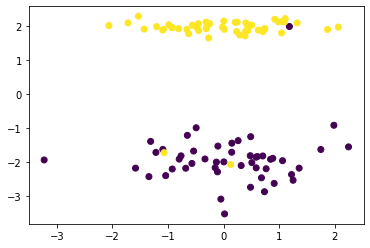

In [79]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=2.0)
plt.scatter(data[:,0],data[:,1],c=target)

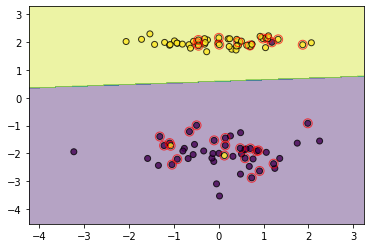

In [80]:
svm = SoftMarginSVM(C=100.0)
svm.fit(data, target)
plot_decision_function(data, target, svm, svm.support_vectors)